In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
from utils import similarity_grade
import argparse
import json


def minmax_scaler(x, scale=(0, 1)):
    min, max = scale
    x = np.array(list(x))
    x_min = x.min()
    x_max = x.max()
    x = (x - x_min) / (x_max - x_min)
    x = x * (max-min) + min
    return x


def subject_labeling(jobname, similarity_method, s2s_threshold):
    subject_grade = {}

    _, _, _, job_subject_sim, _ = similarity_grade(
        jobname, similarity_method, s2s_threshold, grade=1)
    subject_grade = {subject: 1 for subject in job_subject_sim.keys()}
    _, _, _, job_subject_sim, _ = similarity_grade(
        jobname, similarity_method, s2s_threshold, grade=2)
    subject_grade.update({subject: 2 for subject in job_subject_sim.keys()})
    _, _, _, job_subject_sim, _ = similarity_grade(
        jobname, similarity_method, s2s_threshold, grade=3)
    subject_grade.update({subject: 3 for subject in job_subject_sim.keys()})
    return subject_grade


def graph_construction_with_major(jobname, grade=None, similarity_method="tasttext", s2s_threshold=0.9, node_scale=(0, 1), edge_scale=(0, 1)):
    job_major_sim, major_subject_sim, job_subject_sim_1, job_subject_sim_2, subject_subject_sim = similarity_grade(
        jobname, "fasttext", threshold_subject=s2s_threshold, grade=grade)

    majors = list(job_major_sim.keys())
    subjects = list(job_subject_sim_1.keys())
    subject_subject = list(subject_subject_sim.keys())
    majors_weight = list(job_major_sim.values())
    major_subject = []

    subject_subject = [
        (
            list(subject_subject_sim.keys())[idx][0],
            list(subject_subject_sim.keys())[idx][1],
            list(subject_subject_sim.values())[idx],
        )
        for idx in range(len(subject_subject_sim))
    ]
    job_major = [
        (jobname, majors[idx], job_major_sim[majors[idx]])
        for idx in range(len(job_major_sim))
    ]
    for idx in range(len(major_subject_sim)):
        major_subject.extend(
            (majors[idx], subject, major_subject_sim[majors[idx]][subject])
            for subject in major_subject_sim[majors[idx]]
        )
    g = nx.Graph()
    g.add_node(jobname, kind='job', weight=2, color='silver')
    g.add_nodes_from([(node, {'weight': attr, 'kind': 'major', 'color': 'cyan'}) for (
        node, attr) in job_major_sim.items()])
    g.add_nodes_from([(node, {'weight': attr, 'kind': 'subject', 'color': 'paleturquoise'}) for (
        node, attr) in job_subject_sim_2.items()])

    g.add_weighted_edges_from(
        subject_subject, kind='subject-subject', color='silver')
    g.add_weighted_edges_from(
        major_subject, kind='major-subject', color='silver')
    g.add_weighted_edges_from(job_major, kind='job-major', color='silver')

    return g


def graph_construction_without_major(jobname, grade=None, similarity_method="tasttext", s2s_threshold=0.9):
    _, _, _, job_subject_sim_2, subject_subject_sim = similarity_grade(
        jobname, similarity_method, s2s_threshold, grade)

    if grade is None:
        subject_grade = subject_labeling(
            jobname, similarity_method, s2s_threshold)
    else:
        subject_grade = {
            subject: grade for subject in job_subject_sim_2.keys()}

    # majors = list(job_major_sim.keys())
    # subjects = list(job_subject_sim_2.keys())
    subject_subject = list(subject_subject_sim.keys())
    job_subject = []

    subject_subject = [
        (
            list(subject_subject_sim.keys())[idx][0],
            list(subject_subject_sim.keys())[idx][1],
            list(subject_subject_sim.values())[idx],
        )
        for idx in range(len(subject_subject_sim))
    ]

    for _ in range(len(job_subject_sim_2)):
        job_subject.extend(
            (jobname, subject, job_subject_sim_2[subject])
            for subject in job_subject_sim_2
        )

    g = nx.Graph()
    g.add_node(jobname, kind='job', weight=2, color='silver')
    g.add_nodes_from([(node, {'weight': attr, 'kind': 'subject'})
                     for (node, attr) in job_subject_sim_2.items()])
    # set node color by grade
    color_dict = {1: 'green', 2: 'lightgreen', 3: 'yellowgreen'}
    for node in g.nodes():
        if node in subject_grade.keys():
            g.nodes[node]['color'] = color_dict[subject_grade[node]]

    g.add_weighted_edges_from(
        subject_subject, kind='subject-subject', color='lightblue')
    g.add_weighted_edges_from(job_subject, kind='job-subject', color='silver')

    return g


def visualization(g, node_scale=(0, 1), edge_scale=(0, 1), filename="graph"):
    node_colors = nx.get_node_attributes(g, 'color').values()
    node_weight = nx.get_node_attributes(g, 'weight').values()
    edge_colors = nx.get_edge_attributes(g, 'color').values()
    edge_weight = nx.get_edge_attributes(g, 'weight').values()
    num_node = g.number_of_nodes()

    # pos = nx.nx_agraph.graphviz_layout(g, prog="circo")
    pos = nx.nx_agraph.graphviz_layout(g, prog="neato")
    plt.figure(figsize=(max(15, g.number_of_nodes()),
               max(15, g.number_of_nodes())))

    if node_scale != None:
        node_weight = minmax_scaler(node_weight, scale=node_scale)

    if edge_scale != None:
        edge_weight = minmax_scaler(edge_weight, scale=edge_scale)
    nx.draw(
        g,
        pos=pos,
        with_labels=True,
        font_family='Applegothic',
        edge_color=edge_colors,
        node_color=node_colors,
        node_size=[x * 10000 for x in node_weight],
        font_size=np.mean(list(node_weight))*20,
        width=[x * 5 for x in edge_weight],
    )
    plt.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()



def save_weights(job_name, sim_method='fasttext', grade=3):

    job_major_sim, major_subject_sim, job_subject_sim_1, job_subject_sim_2, subject_subject_sim = similarity_grade(
        job_name, sim_method, 0, grade)
    job_major_sim = {k:float(v) for k, v in job_major_sim.items()}
    job_subject_sim_1 = {k:float(v) for k, v in job_subject_sim_1.items()}
    job_subject_sim_2 = {k:float(v) for k, v in job_subject_sim_2.items()}
    subject_subject_sim = {'-'.join(k):float(v) for k, v in subject_subject_sim.items()}

    basedir = f'result/weight/{job_name}_grade{grade}_'
    # save job_major_sim to json
    with open(basedir+'job_major_sim.json', 'w', encoding='utf-8') as f:
        json.dump(job_major_sim, f, ensure_ascii=False, indent=4)

    # save job_subject_sim_1 to json
    with open(basedir+'job_subject_sim_1.json', 'w', encoding='utf-8') as f:
        json.dump(job_subject_sim_1, f, ensure_ascii=False, indent=4)
    # save job_subject_sim_2 to json
    with open(basedir+'job_subject_sim_2.json', 'w', encoding='utf-8') as f:
        json.dump(job_subject_sim_2, f, ensure_ascii=False, indent=4)
    # # save subject_subject_sim to json
    with open(basedir+'subject_subject_sim.json', 'w', encoding='utf-8') as f:
        json.dump(subject_subject_sim, f, ensure_ascii=False, indent=4)



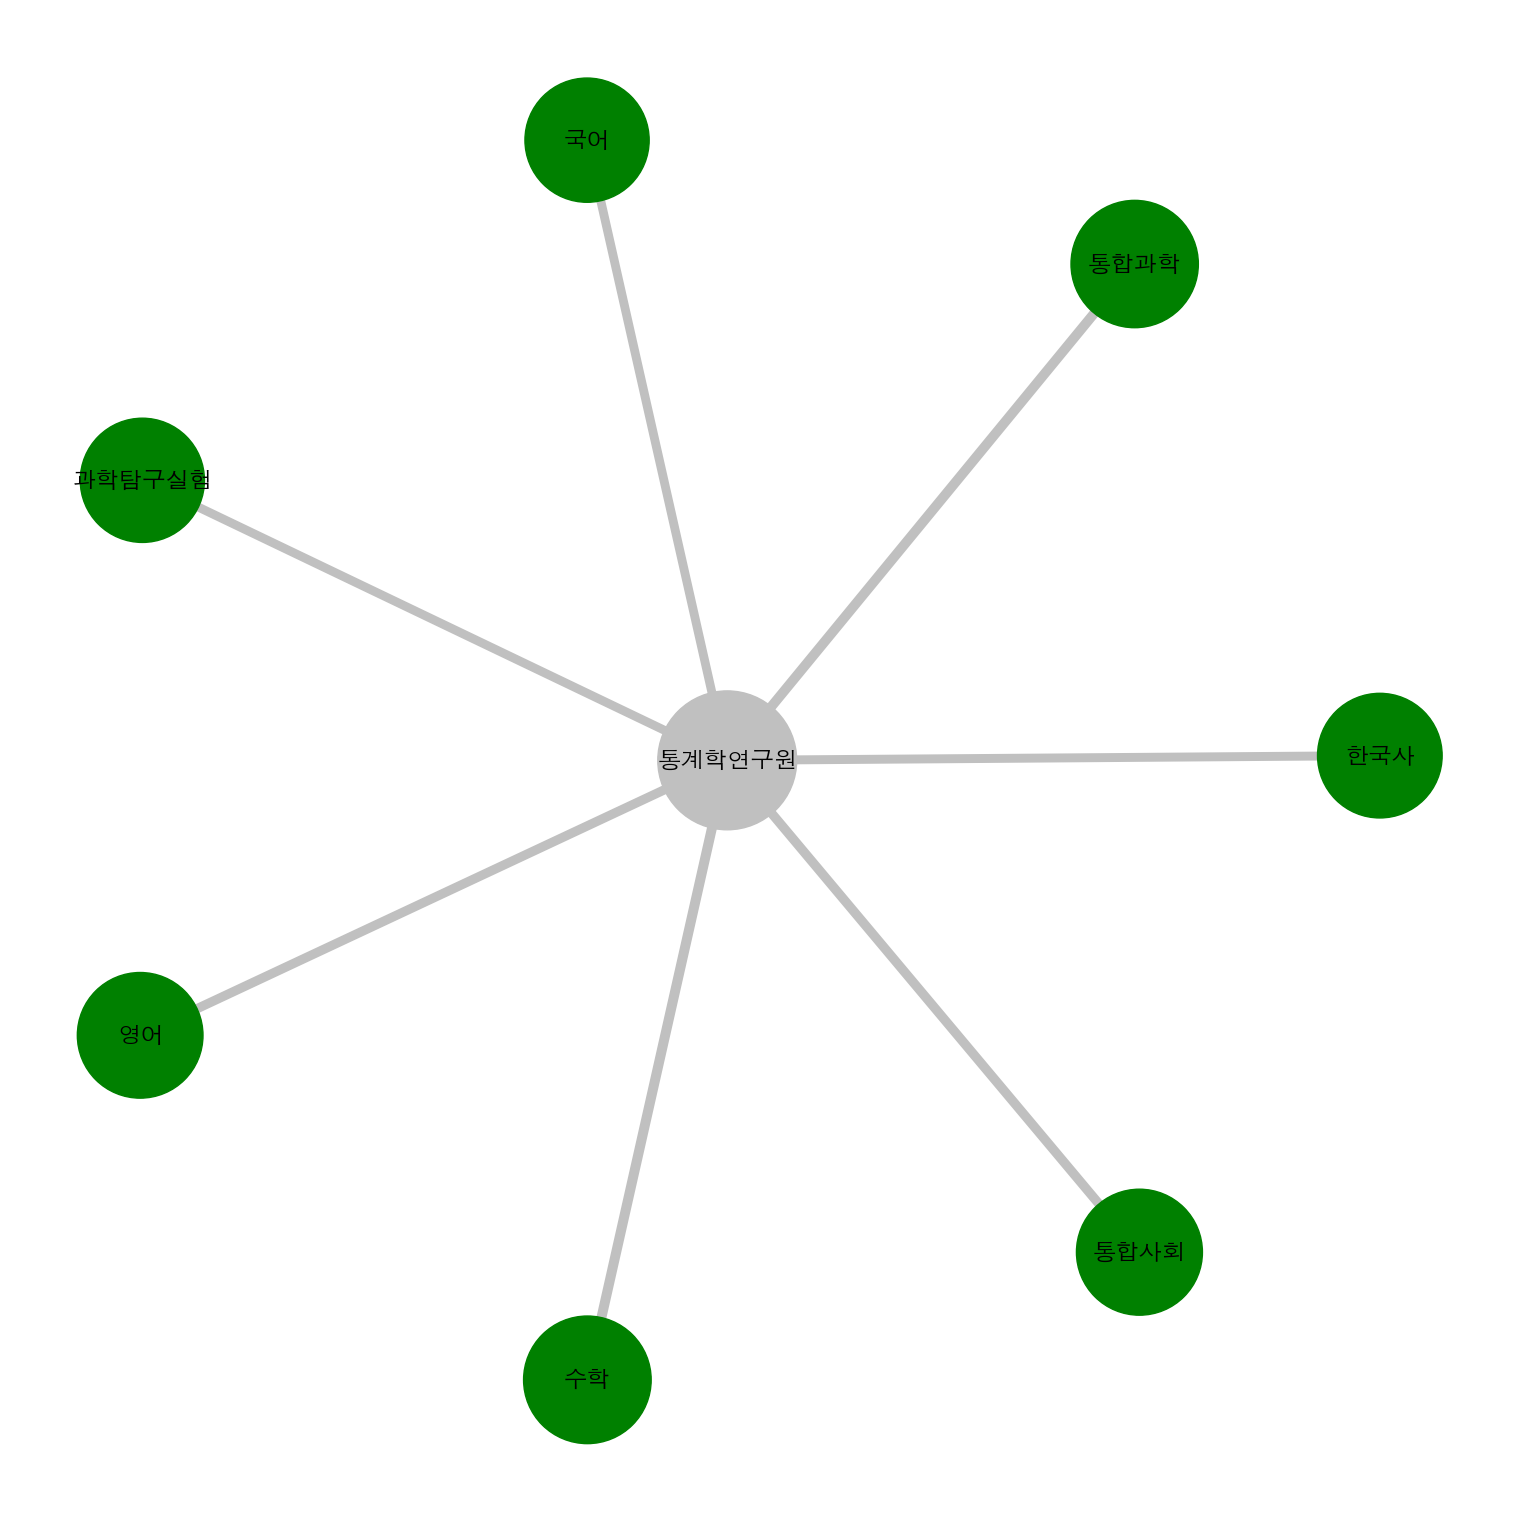

In [5]:

if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument('--jobname', type=str, default='통계학연구원')
    parser.add_argument('--grade', type=int, default='0')
    parser.add_argument('--s2s_threshold', type=float, default=0.9)
    parser.add_argument('--similarity_method', type=str, default='fasttext')
    parser.add_argument('--saveimgdir', type=str, default='result/img/')
    args = parser.parse_args(args=[])

    fn_img = f"{args.saveimgdir}{args.jobname}_grade{args.grade}_s2s{args.s2s_threshold}"

    save_weights(args.jobname, args.similarity_method, grade=args.grade)

    graph = graph_construction_without_major(
        jobname=args.jobname,
        grade=args.grade,
        similarity_method=args.similarity_method,
        s2s_threshold=args.s2s_threshold
    )
    visualization(graph, node_scale=(0.8, 1), edge_scale=None, filename=fn_img)
